# About this demo

Colorization algorithms have a wide range of applications in various fields, such as historical photo restoration and artistic rendering.

This demo shows the how to integrate the state of art AI algorithms into the BMF video processing pipeline. The famous open source colorization algorithm [DeOldify](https://github.com/jantic/DeOldify) is wrapped as an BMF pyhton module in less than 100 lines of codes.


# Acknowledgement
The algorithm used in the demo is forked from the github project [DeOldify](https://github.com/jantic/DeOldify). We want to express our sincere appreciation and gratitude to the authors for this exceptional open-source project.

# Get Started

## 1. Environment Setup

*   install the environment for the deoldify algorithm
*   install the BMF


### 1-1 git clone the deoldify project.
The project is forked from the original github project. We add some suppport for Pillow Image input.

In [ ]:
!git clone https://github.com/eefengwei/DeOldify.git DeOldify

### 1-2 install the dependent python packages

In [ ]:
!pip3 install -r ./DeOldify/requirements-colab.txt

### 1-3 download the pretrained-weights

In [ ]:
!mkdir -p ./DeOldify/models
!wget -c https://data.deepai.org/deoldify/ColorizeVideo_gen.pth -O ./DeOldify/models/ColorizeVideo_gen.pth

### 1-4 pip install BMF packages

In [ ]:
!pip install BabitMF-GPU

### 1-5 verify the FFmpeg libraries is installed and version is correct

BMF framework utilizes the FFmpeg video decoders and encoders as the built-in modules for video decoding and encoding. **It's neccessary for users to install supported FFmpeg libraries before using BMF.**

**Optional step**

Install ffmpeg and related libraries. For this demo, we don't have to do this step, because ffmpeg libraries are already installed in the Google Colab environment.

In [ ]:
!sudo apt install ffmpeg

List the ffmpeg libraries. It is expected that the related libraries such libavcodec, libavformat are installed. The output should be showned as below:
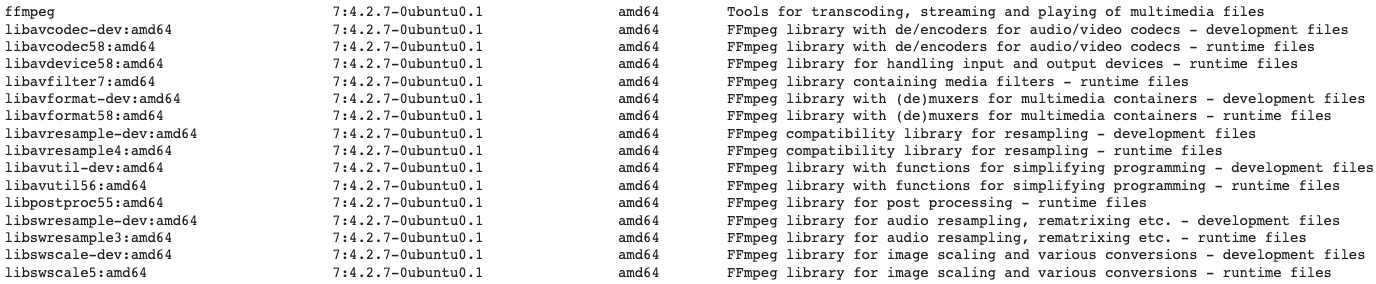

In [ ]:
!dpkg -l | grep -i ffmpeg

Display the FFmpeg version. **BMF supports the FFmpeg verions above 4.2.x.**

In [ ]:
!ffmpeg -version

### 1-6 install wurlitzer

This package is installed to show the BMF C++ logs in the colab console, otherwise only python logs are printed. This step is not necessary if you're not in a Colab or iPython notebook environment.

In [ ]:
!pip install wurlitzer
%load_ext wurlitzer

## 2. BMF processing pipeline programming
*   implement the customized BMF python module, which is the DeOldify video colorization algorithm.
*   set up the BMF processing pipeline (decoding->colorizaiton->encoding) and run it.
*  display the results.

Add the DeOldify folder to the python search path

In [ ]:
import sys
sys.path.insert(0, '/content/DeOldify')
print(sys.path)

### 2-1 Customized BMF module

Implement the customized BMF python module, which is the DeOldify video colorization algorithm.

In [ ]:
%%file py_deoldify_module.py

import bmf
import numpy as np
from bmf import ProcessResult, Packet, Timestamp, VideoFrame
import PIL
import bmf.hmp as mp
from bmf.lib._bmf import sdk

from deoldify import device
from deoldify.device_id import DeviceId
import torch
from deoldify.visualize import *
import warnings

debug = False

class py_deoldify_module(bmf.Module):
    def __init__(self, node, option=None):
        print(f'py_deoldify_module init ...')
        self.node_ = node
        self.option_ = option
        print(option)
        warnings.filterwarnings("ignore", category=UserWarning, message=".*?Your .*? set is empty.*?")

        #NOTE:  This must be the first call in order to work properly!
        #choices:  CPU, GPU0...GPU7
        device.set(device=DeviceId.GPU0)

        if not torch.cuda.is_available():
            print('warning: GPU is not available, the computation is going to be very slow...')

        weight_path=Path('/content/DeOldify')
        if option and 'model_path' in option.keys():
            model_path = option['model_path']
            if not model_path:
                print(f'model_path={model_path}')
                weight_path=Path(model_path)

        self.colorizer = get_stable_video_colorizer(weight_path)
        self.idx = 0

        print(f'py_deoldify_module init successfully...')


    def process(self, task):
        # iterate through all input queues to the module
        idx = self.idx

        for (input_id, input_queue) in task.get_inputs().items():
            # get output queue
            output_queue = task.get_outputs()[input_id]

            while not input_queue.empty():
                # get the earliest packet from queue
                packet = input_queue.get()

                # handle EOF
                if packet.timestamp == Timestamp.EOF:
                    output_queue.put(Packet.generate_eof_packet())
                    task.timestamp = Timestamp.DONE

                # process packet if not empty
                if packet.timestamp != Timestamp.UNSET and packet.is_(VideoFrame):

                    vf = packet.get(VideoFrame)
                    dst_md = sdk.MediaDesc().pixel_format(mp.kPF_RGB24)
                    np_vf = sdk.bmf_convert(vf, sdk.MediaDesc(), dst_md).frame().plane(0).numpy()

                    # numpy to PIL
                    image = Image.fromarray(np_vf.astype('uint8'), 'RGB')

                    colored_image = self.colorizer.colorize_single_frame_from_image(image)

                    if not colored_image:
                        print(f'Fail to process the input image with idx = {idx}')
                        continue

                    if debug:
                        input_name = f'video/bmf_raw/frame_{idx}.png'
                        print(f'input_name = {input_name}')
                        image.save(input_name)

                        output_name = f'video/bmf_out/frame_{idx}.png'
                        print(f'output_name = {output_name}')
                        colored_image.save(output_name)

                    self.idx = idx + 1
                    out_frame_np = np.array(colored_image)
                    rgb = mp.PixelInfo(mp.kPF_RGB24)
                    frame = mp.Frame(mp.from_numpy(out_frame_np), rgb)

                    out_frame = VideoFrame(frame)
                    out_frame.pts = vf.pts
                    out_frame.time_base = vf.time_base

                    pkt = Packet(out_frame)
                    pkt.timestamp = out_frame.pts

                    output_queue.put(pkt)


        return ProcessResult.OK


### Note: Use Colab GPU steps

If you want to use the free GPU provided by Google Colab, please follow such steps:

*   Click on the "Change" tab in the menu bar.
*   Select "Notebook settings" from the dropdown menu.
*   In the "Hardware accelerator" section, make sure "GPU" is selected.
*   Click on the "Save" button.

After saving the changes, your Colab notebook will be configured to run on a GPU. You can verify this by running the following code snippet in a code cell:

In [ ]:
import torch

if torch.cuda.is_available():
    print('GPU is available!')
else:
    print('GPU is not available!')

In [ ]:
!nvcc -V

### 2-2 BMF pipeline setup and execution

input_video_path is the input video path, and output_video_path is the output colored video path. model_weight_path is the path where you download the model weights in step 1-3.

In [ ]:
import bmf
import py_deoldify_module

input_video_path = '/content/DeOldify/test_videos/test_video.mp4'
output_video_path = 'colored_video_2.mp4'
model_weight_path = '/content/DeOldify/'

graph = bmf.graph()

video = graph.decode({"input_path": input_video_path})

output_video = video['video'].module('py_deoldify_module', option={"model_path": model_weight_path})

bmf.encode(
    output_video[0],
    None,
    {"output_path": output_video_path}
    ).run()

### 2-3 Display the processed video

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 800):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"

  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [ ]:
# show input video
show_video(input_video_path)

In [ ]:
# show output video
show_video(output_video_path)